![jakarta](images/banner.png)

**Group:** _Stefan Sack, Stefano Barison_

In [1]:
## Add some custom stilying to the notebook
from IPython.core.display import HTML
#def css_styling():
#    styles = open("custom.css", "r").read() #or edit path to custom.css
#    return HTML(styles)
#css_styling()

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

##TODO: 

 - <s>little introduction?</s>
 - <s>better explanation of ZNE</s>
 - <s>better explanation of "bitstring removal"</s>
 - banner for the intro
 - <s>image for YBE</s>
 - <s>citation for YBE conjecture</s>
 - hide pVQD optimization log and put it in pVQD_log.txt
 - better documentation of the code
 - <s>add pVQD image</s>
 - <s>add pVQD explanation</s>
 - <s>explain decision on qubit routing</s>
 - <s>add better explanation in Trotter functions</s>


## 1 - Introduction

Quantum simulation is one of the first envisioned application of quantum computing and has been proved to be of polynomial complexity on devices making use of quantum resources.

Due to its potential impact on many different areas of physics, chemistry and materials science, significant amounts of research have been devoted to such application.

However, the realisation of an universal quantum simulator remains far in the future due to combined effect of limited connectivity and noisy gates: the noise sets a maximum number of operations that can be performed without affecting the fidelity, while the sparse connection graph among qubits increases the total number of physical operations that must be performed to implement an algorithm.

This challenge required us to consider the $XXX$-Heisenberg spin model 

$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) 
\end{equation}
$$
and significantly improve its state-of-the-art simulation.

In particular, the requirement is to simulate the time evolution of the Heisenberg model with $N=3$ spins arranged in a line and $J=1$ up to $t=\pi$ using at least 4 Trotter steps.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 1.1 - Classical simulation 

We start by showing some classical simulation of the model.

Once we have the Hamiltonian matrix of the system  $H_{\text{Heis3}}$, the time evolution operator that solves the Schrödinger equation can be obtained by matrix exponentiation
$$
\begin{equation}
U_{\text{Heis3}}(t) = e^{-it H_\text{Heis3}} = \exp\left(-it H_\text{Heis3}\right) \, .
\end{equation}
$$

This operation is very accurate, but the computational cost scales exponentially with the system size on a classical computer.

As the system contains only 3 spins, the classical simulation will be the blueprint to evaluate the quality of our quantum simulation.

We start by creating the function that returns the Hesienberg Hamiltonian:

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

and then the function that return the time evolution operator up to time $t$

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian 
# for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

We will use this operator to compute the evolution of the state $|110\rangle$ up to $t=\pi$.

Here below we compute and plot the probability of remaining in $|110\rangle$ state over an array of time points, namely

$$
\begin{equation}
p_{110}(t) =|\langle 110 |e^{-it H_\text{Heis3}}|110\rangle|^2
\end{equation}
$$

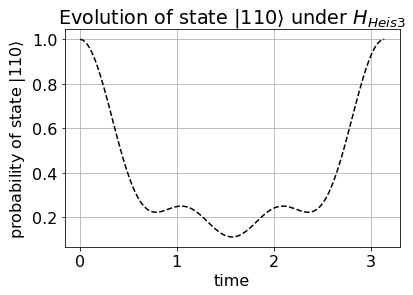

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## 2- The Open Science Prize

We have already said that on a quantum computer the simulation of quantum dynamics is proven to be of polynomial complexity.
This is true provided that we employ the Trotter-Suzuki approximation of the time evolution operator: given an Hamiltonian which can be written has a sum of local terms $H=\sum_l H_l$, we can write

$$
e^{-i\sum_{l}H_l t} = \bigg( \prod_{l} e^{-iH_{l}\frac{t}{n}}\bigg) ^{n} + O\bigg( \frac{t^2}{n}\bigg)
$$

meaning that the time evolution operator can be approximated as a product of local operators, that can be implemented efficiently as quantum gates acting on the qubits.
The error of this approximation can be decreased arbitrarily provided $n$ sufficiently big.
Unfortunately, the depth of such a circuit is of $O(n)$, which means that with current error rates and no error correction schemes at the end the result will be completely dominated by noise.

We are thus required to find a trade-off between simulation accuracy and circuit depth and to make all that we can in order to mitigate the noise acting on the system.

More information on how quantum computers can be used to simualte quantum systems can be found in \[1\], that we will often use as a reference for circuits through this notebook.

In this case, we are required to use at least $4$ steps ($n\geq4$) to time evolve the state $|110\rangle$ to time $t=\pi$ under $H_{\text{heis3}}$.

For this reason, we start from simply considering the Trotter time evolution for different values of $n\geq4$ to assess the accuracy of this approximation.

---
\[1\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]

### 2.1 - Trotterization comparison

For this reason, we will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [6]:
## Import functions from Qiskit
from qiskit                     import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer       import QasmSimulator
from qiskit.tools.monitor       import job_monitor
from qiskit.circuit             import Parameter, ParameterVector
from qiskit.quantum_info        import Statevector, Pauli
from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import PauliOp, SummedOp, CircuitSampler, StateFn

In [7]:
## We have included a file called "trotter_function.py"
## that contains different implementations of a Trotter step that we will use in this notebook

# In this case, we import the standard Trotterization of the XXX Hamiltonian 
# as indicated in Fig. 4a of arXiv:1907.03505v2
from trotter_functions import Heisenberg_Trotter

We start from the naive approach to Trotterization, that requires implementing every gate $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$ separately, as indicated in Fig. 4a of \[1\]. For 3 spins and $n$ Trotter steps this has the form:

$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$

where the superscript $(i,j)$ indicates on which spins (qubits) the operator is acting on.

---
\[1\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]

In [8]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8 and 12 Trotter steps
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

# We cycle on different number of Trotter steps
for n in probs_110_trott.keys():
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step = Heisenberg_Trotter(num_qubits=3,trotter_steps=n,t=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[n].append(trott_ovp)
    print(str(n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


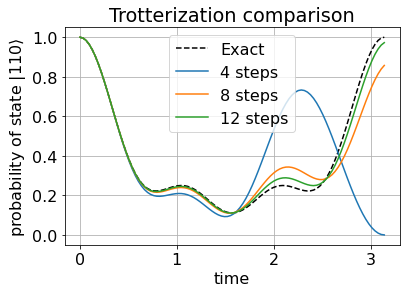

In [9]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, increasing the number of Trotter steps we get closer and closer to the exact simulation.

However, in the present form a single Trotter step requires 12 CNOTs, resulting 48 CNOTs for $n=4$ and 144 CNOTs for $n=12$, a circuit too deep for current hardware. This forces us to compress the greatest Trotterization accuracy into the shortest possible circuit, before even applying error mitigation techniques.

### 2.2 Compress the Trotter step

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $XX+YY+ZZ$ rotation presented in in Fig. 4b of \[1\].

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48.

---
\[1\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]

In [10]:
# From the same file as before, we import the compressed Trotterization of Fig. 4b of arXiv:1907.03505v2
from trotter_functions import Heisenberg_Trotter_compressed

/opt/anaconda3/envs/qiskit_0.32.1/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


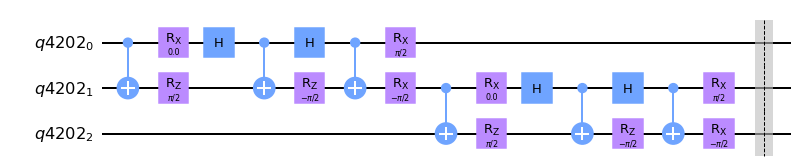

In [11]:
## Ad an example of a single Trotter step using the optimized decomposition

compression_example = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=1,t=t,target_time=np.pi/4)
compression_example.decompose().decompose().draw(output='mpl')

To show that the two decompositions are equivalent, let us simulate again the system with $4$ steps up to $t=\pi$.

In [12]:
probs_110_trott_c = []
for sim_t in ts:
    # Initialise the circuit
    trott_qr_c = QuantumRegister(3)
    trott_qc_c = QuantumCircuit(trott_qr_c)
    trott_qc_c.x([1,2])
    
    # Append the Trotterization
    trott_step_c = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,t=t,target_time=sim_t).to_instruction()
    trott_qc_c.append(trott_step_c, [trott_qr_c[0], trott_qr_c[1], trott_qr_c[2]])
    
    # Measure the overlap with |110> As in the first case
    trott_wfn_c = CircuitStateFn(trott_qc_c)
    trott_ovp_c = np.abs((~initial_state@trott_wfn_c).eval())**2
    probs_110_trott_c.append(trott_ovp_c)

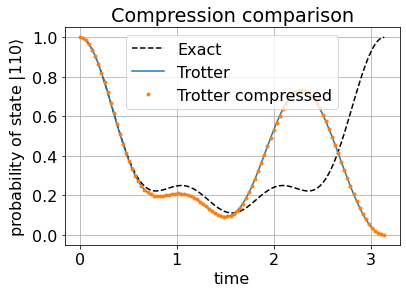

In [13]:
## Now plot the exact simulation, the initial Trotter and the Trotter compressed
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott[4],color="C0",label="Trotter")
plt.plot(ts, probs_110_trott_c,color="C1",marker=".",linestyle="",label="Trotter compressed")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Compression comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, the two circuits give the exact same probability at all times!

### 2.3 Using the Yang - Baxter Equivalence (YBE) 

The circuit now has 24 CNOTs which is already very good, though it can be compressed even further!

To this end we will be using the Yang-Baxter Equation (YBE) \[2\] which has recently been used by \[3\] to compress the circuit for a Trotterized time evolution of the XY Heisenberg model. 

The YBE equation works in the following way:

![YBE](images/YBE.png)

$\mathcal{R}$ is in our case one $XX+YY+ZZ$ rotation on a pair of qubits. The YBE tells us that we can mirror whenever we encounter three $\mathcal{R}$ terms. Repeating this procedure allows to bring multiple $\mathcal{R}$ onto the same pair of qubits, they can then be combined into a single rotation with a new rotational angle. In our case this allow us to propose a circuit with only $15$ CNOT gates instead of $24$. 

Unfortunately, the paper doesn't present an analytical relationship between the Trotter circuit and the YBE-compressed circuit rotational angles when considering the XXX Hamiltonian. It is however conjectured to generally exist for gates with such alternating pattern (see \[4\]).

Since there is no known analytical expression for the new angles of the compressed circuit in our case, we propose to find them variationally.

We want to highlight that we are not going to use these parameters in the final circuit.
The aim of this section is to demonstrate that at every time $t$ a set of parameters can be found in order for the YBE circuit to be equivalent to the Trotter one. Even if the relationship is not known analitically, we find it variationally. 

---
\[2\] Jimbo M. , *Introduction to the Yang-Baxter Equation*, [International Journal of Modern Physics A, vol. 04, no.15](https://www.worldscientific.com/doi/epdf/10.1142/S0217751X89001503)

\[3\] Gulania et al, *Quantum time dynamics of 1D-Heisenberg models employing the Yang-Baxter equation for circuit compression*, [ArXiv:2112.01690](https://arxiv.org/abs/2112.01690)

\[4\] Bassman et al, *Constant-Depth Circuits for Dynamic Simulations of Materials on Quantum Computers*,[ArXiv:2103.07429](https://arxiv.org/abs/2103.07429)

In [14]:
# Import the YBE circuit 
# The function returns the circuit corresponding to the YBE compression of a 4 Trotter steps circuit in 3 spins 
from trotter_functions import Heisenberg_YBE_variational

/opt/anaconda3/envs/qiskit_0.32.1/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


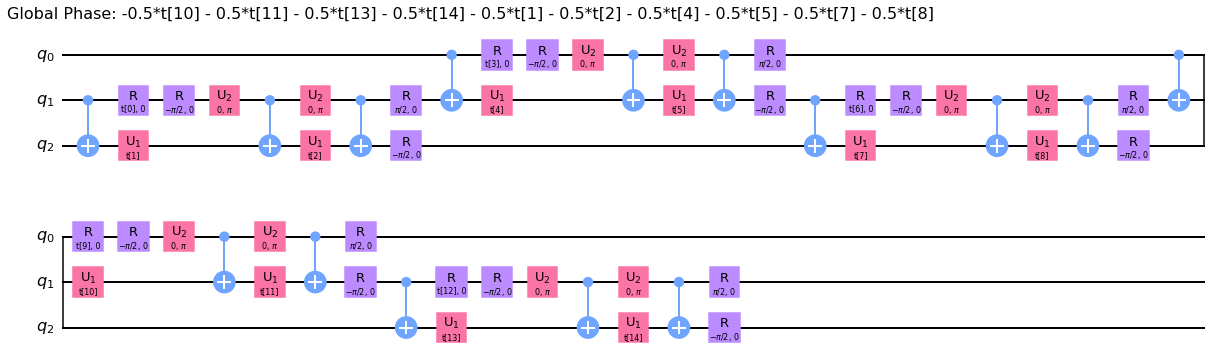

In [15]:
# Here we show an example of the circuit
example = Heisenberg_YBE_variational(ParameterVector('t',15))
example.decompose().draw(output='mpl')

At every time $t$, we want the YBE circuit to be equivalent to the Trotter circuit with 4 steps.

We will do so by  finding $\theta_{t}$ that maximizes at every time $t$ the overlap

$$
|\langle \psi_0 |U^{\dagger}_{T}(t)U_{YBE}(\theta_t) |\psi_0\rangle|^2 \,
$$

where $U_{T}(t)$ indicates the 4-steps Trotter-Suzuki circuit, $U_{YBE}(\theta_t)$ is its compressed version with the Yang Baxter equation and $|\psi_0\rangle = U_0|000\rangle =|110\rangle$.

To do this on a quantum circuit, we will use the compute-uncompute method as follow:

given

$$
|\langle \psi_0 |U^{\dagger}_{T}(t)U_{YBE}(\theta_t) |\psi_0\rangle|^2 = 
\langle 000| U^{\dagger}_0 U^{\dagger}_{YBE}(\theta_t)U_{T}(t)U_0
|000\rangle \langle 000| 
U^{\dagger}_0U^{\dagger}_{T}(t)U_{YBE}(\theta_t)U_0|000\rangle = \langle \psi|P_0|\psi\rangle
$$

we prepare the state $|\psi\rangle = U^{\dagger}_0U^{\dagger}_{T}(t)U_{YBE}(\theta_t)U_0|000\rangle$ and measure the operator $P_{0} =|000\rangle \langle 000|$.

Then, we compute the gradient of this expectation value using the parameter-shift rule and pass this information to a classical optimizer like ADAM \[6\] to update the YBE parameters $\theta_t$.

Therefore, we need a method to compute this overlap and its gradient, then a method to update the parameters.

---
\[5\] A. Mari et al, *Estimating the gradient and higher-order derivatives on quantum hardware*, [Phys. Rev. A 103 012405](https://doi.org/10.1103/PhysRevA.103.012405)

\[6\] Kingma D. P. and Ba J.L. , *Adam: A Method for Stochastic Optimization*, [ArXiv: 1412.6980](https://doi.org/10.48550/arxiv.1412.6980)

In [16]:
from pVQD    import adam_gradient, projector_zero, ei

In [17]:
def ybe_overlap_and_gradient(θ_params,state_wfn,θ_t,sampler):
    
    '''
   This function computes the overlap between the wavefunction obtained with 4 Trotter steps at time t
   and the YBE compressed circuit.
   It also computes the gradient with the respect to the YBE parameters, using the parameter-shift rule
    
    Args:
        - θ_params   : Qiskit ParameterVector, to bind θ_t parameters and shifts for gradient
        - state_wfn  : StateFn P_0 @ |ψ> converted by Qiskit Expectator
        - θ_t        : the array of parameters for U_{YBE}(θ_t)
        - sampler    : Qiskit CircuitSampler to sample from the circuit created given the QuantumInstance
        
    Returns:
        - Overlap between U_T(t)|110> and U_{YBE}(θ_t)|110>
        - Gradient with respect to the YBE parameters
    '''

    nparameters = len(θ_t)
    # build dictionary of parameters to values
    # {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
    # First create the dictionary for overlap
    values_dict = [dict(zip(θ_params[:], θ_t.tolist()))]


    # Then the values for the gradient
    for i in range(nparameters):
        values_dict.append(dict(zip(θ_params[:] , (θ_t  + ei(i,nparameters)*np.pi/2.0).tolist())))
        values_dict.append(dict(zip(θ_params[:] , (θ_t  - ei(i,nparameters)*np.pi/2.0).tolist())))

    # Now evaluate the circuits with the parameters assigned and save the results in a list 

    results = []

    for values in values_dict:
        sampled_op = sampler.convert(state_wfn,params=values)
        # It's an exact value, no statistical uncertainties
        mean    = sampled_op.eval().real

        results.append(mean)
    
    # The first element of the result list is the overlap
    E = results[0]
    g = np.zeros(nparameters)

    
    # Parameter shift rule to evaluate the gradient components
    for i in range(nparameters):
        rplus  = results[1+2*i]
        rminus = results[2+2*i]
        # G      = (Ep - Em)/2
        g[i] = (rplus-rminus)/2.0

    return E,g

In [18]:
## Define quantities for the optimization

# Array of time points for the YBE compression example
ybe_ts         = np.linspace(0, np.pi, 60)

# For YBE circuit
ybe_params_vec = ParameterVector('θ',15)
# Initial parameters
ybe_parameters = np.zeros(15)
num_parameters = len(ybe_parameters)

# Parameter for Trotter circuit
t              = Parameter("t")

# For the optimization
# Number of parameter optimizations per time step
opt_steps      = 600
# Overlap threshold
opt_ths        = 0.9999
# P_0 = |000><000|
zero_prj       = StateFn(projector_zero(3),is_measurement = True)

In [19]:
## Create QuantumInstance to run the circuit
backend     = Aer.get_backend('statevector_simulator')
instance    = QuantumInstance(backend=backend)
expectation = PauliExpectation()
sampler     = CircuitSampler(instance)

In [51]:
ybe_params = []

print("Starting YBE compression...")

for (t_step,sim_t) in enumerate(ybe_ts):

    ## Create the optimization circuit
    # Define the left- hand circuit U_T(t)|110>
    l_ansatz   = QuantumCircuit(3)
    l_ansatz.x([1,2])
    l_ansatz   = l_ansatz.compose(Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,t=t,target_time=sim_t))
    
    # Define the righ-hand circuit U_{YBE}(theta_t)|110>
    r_ansatz   = QuantumCircuit(3)
    r_ansatz.x([1,2])
    r_ansatz   = r_ansatz.compose(Heisenberg_YBE_variational(ybe_params_vec))
    # Create the binding for the parameters
    r_circ     = r_ansatz.assign_parameters({ybe_params_vec: ybe_params_vec})

    total_circ = r_circ+l_ansatz.inverse()
    state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))


    # Initialise step-quantities
    count          = 0
    max_ovp        = 0.01
    new_parameters = ybe_parameters

    # Initialise quantities for the Adam optimiser
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)
    
    # Optimize the parameters for #opt_step and up to opt_ths
    while max_ovp < opt_ths and count < opt_steps:
        
        count = count +1 

        ## Measure energy and gradient

        E,g = ybe_overlap_and_gradient(ybe_params_vec,state_wfn,new_parameters,sampler)

        # Update the parameters using the evaluated gradient and ADAM optimizer
        meas_grad = np.asarray(g)
        new_parameters = np.asarray(adam_gradient(new_parameters,new_parameters,count,m,v,meas_grad))

        # Save the best set of parameters found for each time-step
        if E > max_ovp:
            max_ovp        = E
            ybe_parameters = new_parameters
    

    ybe_params.append(list(ybe_parameters))
    # Update parameters
    if t_step%15 == 0:
        print('----------------------------------')
        print("Step: ",t_step,", overlap: " ,max_ovp)

print('----------------------------------')
print("YBE compression completed")

Starting YBE compression...
----------------------------------
Step:  0 , overlap:  0.9999999999999992
----------------------------------
Step:  15 , overlap:  0.999902124267443
----------------------------------
Step:  30 , overlap:  0.9999051240899332
----------------------------------
Step:  45 , overlap:  0.999902009004354
----------------------------------
YBE compression completed


Now that the optimization is finished, we want to compute the overlap with the target state $|110\rangle$ at every time $t$:

In [20]:
def ybe_probs_target(target,ybe_circ,param_list):
    
    '''
    A function to compute the probability of being in a target state given a YBE circuit.
    
    Args:
        - target     : the target state
        - ybe_circ   : Qiskit parameterized QuantumCircuit
        - param_list : the list of different parameters
        
    Returns:
        The list of probabilities to be in the target state
    '''

    ovlp_list = []
    
    for params in param_list:
        # Create the circuit
        circ   = QuantumCircuit(3)
        circ.x([1,2])
        circ   = circ.compose(ybe_circ(params))
        # Extract the wavefunction at time t
        wfn_t  = CircuitStateFn(circ)
        # Evaluate the overlap with the target state
        ovlp_t = np.abs((~target@wfn_t).eval())**2

        ovlp_list.append(ovlp_t)

    return ovlp_list

In [53]:
probs_110_ybe  = ybe_probs_target(One^One^Zero,Heisenberg_YBE_variational,ybe_params)

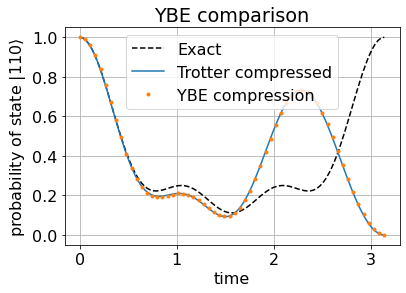

In [54]:
## Now plot the exact simulation, the Trotter compressed and the YBE equivalent
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott_c,color="C0",label="Trotter compressed")
plt.plot(ybe_ts, probs_110_ybe,color="C1",marker=".",linestyle="",label="YBE compression")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'YBE comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, at every time $t$ we are able to find a set of parameters that makes the YBE compressed circuit with $15$ equivalent to the $24$ CNOTs Trotter circuit.

From this moment on, we will be using this circuit for the challenge.

### 2.4 Qubit routing


Note, that due to the circuit compression there is now an unequal number of CNOT gates acting on the two pairs of qubits. 
We know that in the Jakarta hardware the error rates between qubit $3$ and $5$ are lower than between $1$ and $3$, 
we therefore chose to compress the circuit such that one more CNOT is acting on qubits $3$ and $5$ than on $1$ and $3$.

![jakarta](images/jakarta.png)

### 2.5 Variational compression - the pVQD algorithm

We showed that the YBE circuit is equivalent to the Trotter circuit with 4 Trotter steps.
For this reason, we will have the same accuracy.

We want to increase the representation accuracy of our circuit without increasing the number of gates, that would add more and more noise due to the high error rates.

To this end, we introduce the projected - Variational Quantum Dynamics (pVQD) algorithm \[7\]. 
This method is used to approximate variationally the time evolution of quantum system on quantum computers.

We will use it in a slightly different way: instead of considering a generic variational ansatz, we will use the circuit obtained using the YBE compression and optimize its parameters to improve the accuracy of the simulation, not only for the final time $t=\pi$, but also for the whole simulation.

We highlight that the same technique can be used on the 24 CNOTs Trotterization, with the same results.
However, on hardware the number of CNOTs implied will make the difference on the final fidelity. 

We proceed illustrating the algorithm briefly:

 1) we consider a total simulation time `target_time` and divide it into many discrete time steps of length $dt$
 
 2) for every time step $t$ we want to minimize the cost function 
 $$
 L = \frac{1-|\langle 110|U^{\dagger}_{YBE}(\theta_t +d\theta)U_{T}(dt)U_{YBE}(\theta_t)|110\rangle|^2}{dt^2}
 $$ 
     by optimizing $d\theta$ and, therefore, the overlap in the numerator
 
 3) we use again the compute-uncompute method, preparing $U^{\dagger}_0U^{\dagger}_{YBE}(\theta_t +d\theta)U_{T}(dt)U_{YBE}(\theta_t)U_0|000\rangle$ and measuring $P_0$ as in the YBE compression
 
 4) we use the parameter-shift rule to measure the gradient and optimize $d\theta$
 
 5) Once the cost function $L$ has converged with $d\theta_{opt}$, we can proceed to the next time step using     $\theta_{t+1} = \theta_t + d\theta_{opt}$ 

A sketch of the algorithm from the paper can be found below (here $w = \theta$, but we kept $\theta$ for consistency)

![pvqd_sketch](images/pvqd_sketch_resized.png)

![pvqd_sketch](images/pvqd_sketch_minimized.png)

We note that we are not modifying the circuit, instead we are optimizing the same gates in order to make the circuit contain a more accurate state.

---
\[7\] Barison S. et al, *An efficient quantum algorithm for the time evolution of parameterized circuits*, [Quantum 5, 512](https://doi.org/10.22331/q-2021-07-28-512)

As for the YBE compression, we need a function to compute the overlap and its gradient.

The function will be very similar to the old one, with the excpetion that now both the left- and the right-hand circuits will contain parameters.

In [21]:
def pvqd_overlap_and_gradient(θ_l,θ_r,state_wfn,θ_t,dθ,sampler):
    
    '''
   This function computes the overlap between the wavefunction obtained with 4 Trotter steps at time t
   and the YBE compressed circuit.
   It also computes the gradient with the respect to the YBE parameters, using the parameter-shift rule
    
    Args:
        - θ_l        : Qiskit ParameterVector for the left-hand circuit, to bind θ_t+dθ parameters
        - θ_r        : Qiskit ParameterVector for the right-hand circuit, to bind θ_t parameters
        - state_wfn  : StateFn P_0 @ |ψ> converted by Qiskit Expectator
        - θ_t        : the array of parameters for U_{YBE}(θ_t)
        - dθ         : the shift of the parameters between θ_t and θ_{t+1}, to be optimized
        - sampler    : Qiskit CircuitSampler to sample from the circuit created given the QuantumInstance
        
    Returns:
        - Overlap between U_{YBE}(θ_t+dθ)|110> and U_T(dt)U_{YBE}(θ_t)|110>
        - Gradient with respect to dθ
    '''

    nparameters = len(θ_t)
    # build dictionary of parameters to values
    # {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
    # First create the dictionary for overlap
    values_dict = [dict(zip(θ_r[:] + θ_l[:], θ_t.tolist() + (θ_t + dθ).tolist()))]


    # Then the values for the gradient
    for i in range(nparameters):
        values_dict.append(dict(zip(θ_r[:] + θ_l[:], θ_t.tolist() + (θ_t + dθ + ei(i,nparameters)*np.pi/2.0).tolist())))
        values_dict.append(dict(zip(θ_r[:] + θ_l[:], θ_t.tolist() + (θ_t + dθ - ei(i,nparameters)*np.pi/2.0).tolist())))

    # Now evaluate the circuits with the parameters assigned

    results = []

    for values in values_dict:
        sampled_op = sampler.convert(state_wfn,params=values)

        mean  = sampled_op.eval().real
        results.append(mean)


    g = np.zeros(nparameters)
    
    # The first element in the results array is the overlap
    E = results[0]
    
    # Parameter shift rule to evaluate the gradient components
    for i in range(nparameters):
        rplus  = results[1+2*i]
        rminus = results[2+2*i]
        # G      = (Ep - Em)/2
        g[i] = (rplus-rminus)/2.0

    return E,g 

In [22]:
# As before, we create the QuantumInstance to run the circuit on the simulator
# and use it to initialise the expectator and the sampler
backend       = Aer.get_backend('statevector_simulator')
instance      = QuantumInstance(backend=backend)
expectation   = PauliExpectation()
sampler       = CircuitSampler(instance)

In [34]:
# Initialize parameters and ParameterVector for the pVQD
θ_t            = np.zeros(15)
num_parameters = len(θ_t)
dθ             = 0.01*np.ones(15)
θ_params_vec   = ParameterVector('θ',num_parameters)

# Different ParameterVector for left and right circuit
θ_l            = ParameterVector('l', num_parameters)
θ_r            = ParameterVector('r', num_parameters)

# Define the evolution time and the time step
dt             = np.pi/60
n_steps        = 60
# Array of time points for the pVQD
pvqd_ts        = [i*dt for i in range(n_steps+1)]
# Parameter for Trotter circuit
t              = Parameter("t")

# Number of optimisation steps and threshold
max_iter       = 100
pvqd_ths       = 0.9999


## Now prepare the state in order to compute the overlap and its gradient
# First use a single compressed Trotter step
U_dt           = Heisenberg_Trotter_compressed(3,1,t,dt)

# The YBE circuit for the pVQD algorithm, initalizing the state at |110>
ansatz         = QuantumCircuit(3)
ansatz.x([1,2])
ansatz         = ansatz.compose(Heisenberg_YBE_variational(θ_params_vec))

# Then, create the total circuit

l_circ         = ansatz.assign_parameters({θ_params_vec: θ_l})
r_circ         = ansatz.assign_parameters({θ_params_vec: θ_r})
zero_prj       = StateFn(projector_zero(U_dt.num_qubits),is_measurement = True)
total_circ     = r_circ.compose(U_dt)+l_circ.inverse()
state_wfn      = expectation.convert(zero_prj @ StateFn(total_circ))

In [30]:
print("Running the pVQD algorithm")

pvqd_params = []
pvqd_params.append(list(θ_t))


for i in range(n_steps):
    
    if i%15 == 0:
        print('----------------------------------')
        print("Time slice:",i)

    count = 0
    E     = 0.01

    # Initialise quantities for the Adam optimiser
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)


    while E < pvqd_ths and count < max_iter:
        
        count = count +1 

        ## Measure energy and gradient
        E,g = pvqd_overlap_and_gradient(θ_l,θ_r,state_wfn,θ_t,dθ,sampler)
       

        meas_grad = np.asarray(g)
        dθ        = np.asarray(adam_gradient(dθ,count,m,v,meas_grad))


    # Update parameters

    if i%15 == 0:
        print("pVQD overlap: ",E)

    θ_t = θ_t + dθ
    pvqd_params.append(list(θ_t))
    
print("pVQD: Done, parameters list created")

Running the pVQD algorithm
----------------------------------
Time slice: 0
pVQD overlap:  0.9999017173988116
----------------------------------
Time slice: 15
pVQD overlap:  0.9999014453118512
----------------------------------
Time slice: 30
pVQD overlap:  0.9999036155460497
----------------------------------
Time slice: 45
pVQD overlap:  0.9999069603353266
pVQD: Done, parameters list created


From the pVQD routine we get a list of parameters sets.

What we are interested in is the last set of parameters, corresponding to the evolution of the wavefunction at the final time $t=\pi$.

For completeness, we will also plot the probability of geting $|110\rangle$ throught the overall evolution.

In [32]:
probs_110_pvqd   = ybe_probs_target(One^One^Zero,Heisenberg_YBE_variational,pvqd_params)

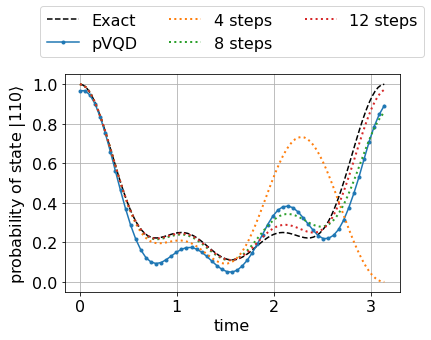

In [33]:
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(pvqd_ts,probs_110_pvqd,label="pVQD",marker=".",color="C0")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i+1),label=str(n)+" steps",linewidth=2,linestyle="dotted")

plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.35),ncol=3,fancybox=True)
plt.grid()
plt.show()

As can be seen, we have an improvement through the whole simulation, not just for the final state.
At $t \sim 1.5$ the Trotter approximation with $4$ steps starts detaching from the exact simulation, while the pVQD stay closer, with performances comparable to the 12 steps approximation.

We highlight that this technique is completely general: given a Trotter step $U(dt)$ we can compress its repeated application into a variational circuit of choice.

Moreover, this technique can also be performed entirely on hardware, as shown in [this article](https://arxiv.org/pdf/2112.12654.pdf).

In [31]:
#Here we show the parameters that we are going to use 
pvqd_opt_params = pvqd_params[-1]
pvqd_opt_params

[-0.2269989117849683,
 1.1999999999461293,
 -0.2269989117858616,
 1.0413663536234699,
 3.032716488699106,
 -1.589258444259985,
 -1.01248355818748,
 -2.5188592667032963,
 -4.1431374317175305,
 0.2956233214289077,
 -0.7274377186637956,
 2.920199494684063,
 10.441941953743155,
 6.68948736551498,
 -7.145404354806929]

# 3- Final Implementation

## 3.1 Error mitigation

To optimize the results that are obtained with the current noise level on quantum computers we will use two different strategies for error mitgation. The general idea for error mitigation is to try to estimate what the output of the quantum computer would be with a smaller noise level. For this there already exists a plethora of different strategies, though it is still a very active field of research. For our purposes we will two different simple strategies to vastly improve the final fidelity that is obtained in the tomography. 

### 3.1.1 Zero Noise Extrapolation

Zero Noise Extrapolation (ZNE) is a common tool to estimate what the output would be on a quantum computer without any noise. To do this, the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$, so in essence simply inserting the identity. The circuit remains the same this way (since $G^\dagger G = I$), though the noise level is increased. This way we can obtain results for different noise levels and extrapolate to the ideal, zero noise case. This prodecure is readily implemented in [mitiq](https://mitiq.readthedocs.io/en/stable/from). In particular, we will unfold the circuit a total of 5 times and extrapolate the noise level to zero by fitting the counts that are obtained in the tomography to a third order polynomial. Written out as an equation we roughly have $\text{counts}(x)=a+bx+cx^2+dx^3$, where $x$ is the noise level that is controlled by the number of unfoldings that are used. Once the paramters $a$, $b$ ,$c$ and $d$ are fitted, the expression is evalutated for the zero noise level ($x=0$). Which is then the counts that we use for the fidelity estimation. 

In [23]:
## Mitiq import and helper functions
import re
import copy
from mitiq import zne
from itertools import chain
from qiskit.result import Result
from qiskit.result.models import ExperimentResult
from qiskit.result.models import ExperimentResultData
from qiskit.result.models import QobjExperimentHeader

In [39]:
# We use a total of 5 unfolds
scale_factors = [1.0, 2.0, 3.0, 4.0, 5.0]

In [43]:
def zne_job_launch(tomo_circs, backend, optimization_level, shots, scale_factors):

    # This function executes the tomography circuits on hardware with unrolled gates to increase the noise level
    noise_scaled_circuits = [[zne.scaling.fold_global(circ, s) for s in scale_factors] for circ in tomo_circs] 
    noise_scaled_circuits = list(chain(*noise_scaled_circuits)) 
    
    job = execute(noise_scaled_circuits, backend=backend, optimization_level=optimization_level, shots=shots)
    job_id = job.job_id()

    print("JOB "+str(job_id)+" SUBMITTED")
    
    return str(job_id)

In [41]:
def zne_results_collect_nofile(backend, jobid, tomo_circs, zne_order, shots, scale_factors):

    # This function runs the tomography circuits and unrolls the gates to increase the noise level
    # The counts that are obtained for the differnt noise levels are then extrapolated to the zero-noise level
    
    job = backend.retrieve_job(jobid) 
    result = job.result()
    
    count_list = result.get_counts()
    ordered_bitstrings = dict(sorted(count_list[0].items()))
    
    zne_result_list = []

    for i in range(len(tomo_circs)):
        counts_dict = {}

        # Loop over the results of the scaled circuits and collect the data in the correct form
        for key in ordered_bitstrings.keys():
            counts_list_zne = []
            for count in count_list[i*len(scale_factors):len(scale_factors)*(i+1)]:
                counts_list_zne.append(count[key])
            # Here we extrapolate the counts to zero noise and round to the closest integer
            zne_counts_value = int(zne.PolyFactory.extrapolate(scale_factors, counts_list_zne, order=zne_order)) 
            if zne_counts_value < 0:
                zne_counts_value = 0
            counts_dict[key] = zne_counts_value
        zne_result_list.append(counts_dict)
        
    # To work with the StateTomographyFitter we need to put the result into a Qiskit Result() object
    name_list = [circ.name for circ in tomo_circs]
    results_tmp = [[ExperimentResult(shots=shots, success=True, data=ExperimentResultData(counts=result_i), header=QobjExperimentHeader(name=name_i))] for (name_i, result_i) in zip(name_list, zne_result_list)]
    results = [Result(backend_name="zne", backend_version="zne", qobj_id='0', job_id='0', success=True, results=result_i) for result_i in results_tmp]

    return results, tomo_circs

### 3.1.2 Removal of unphysical bitstrings

There is one last error mitigation that we will use to further improve our results. In particular, we know that for the Heisenberg model $H_{\text{Heis}}$ the magnetization $M=\sum_i \sigma_i^z$ is a conserved quantity. This can be seen from the fact that it commutes with the Hamiltonian $[H_{\text{Heis}}, M]=0$. The initial state $|110\rangle$ that we time evolve has a magnetization of $M=2$ since two spins are in the $1$ state. The magnetization $M$ thus has to be conserved during our time evolution. This allows us to remove some unphysical bitstrings that are obtained due to hardware noise in the tomography. In the state tomography local basis changes are performed to obtain the counts in the $x$, $y$ and $z$-basis. There are two types of circuits for which we can remove unphysical bitstrings. Namely, the one where all qubits are measured in the $z$ basis and the ones where two qubits are measured in the $z$-basis. For the first we know that bitstrings with either all qubits in the $1$ state or all qubits in the $0$ state are unphysical since they give a magnetization of $3$ and $0$, respectively. For the second circuit type we know that for both the qubits that are measured in the $z$-basis the qubits cannot both be in the $0$ state since the remaining qubit that is measured in a different basis, regardless of its state, is not enough to obtain a total magnetization of $2$. In total there are 7 circuits for which we can set uphysical counts to zero.

In [42]:
def remove_unphysical_bitstrings(result):

    # This function loops over the result that is obtained from the tomography 
    # and removes the bitstrings that violate the conservation of the magnetization
    result_new = copy.copy(result)
    for i in range(len(result_new)):
        name = result_new[i].results[0].header.name
        res = "".join(re.findall("[XYZ]+", name))
        res_2 = "".join(re.findall("[Z]+", res))
        
        # Set unphysical bitstrings to zero if all qubits are measured in the z-basis
        if len(res_2) == 3:
            bitstring_1 = res.replace('Z', '0')
            bitstring_2 = res.replace('Z', '1')
            result_new[i].results[0].data.counts[bitstring_1] = 0
            result_new[i].results[0].data.counts[bitstring_2] = 0

         # Set unphysical bitstrings to zero if two qubits (out of three) are measured in the z-basis
        if len(res_2) == 2:    
            bitstring = res.replace('Z', '0')
            bitstring_1 = bitstring.replace('X', '0')
            bitstring_1 = bitstring_1.replace('Y', '0')
            bitstring_2 = bitstring.replace('X', '1')
            bitstring_2 = bitstring_2.replace('Y', '1')
            result_new[i].results[0].data.counts[bitstring_1] = 0
            result_new[i].results[0].data.counts[bitstring_2] = 0

    return result_new

## 3.2 Execution on hardware

In [26]:
pvqd_opt_params = [0.6382017062070897,
0.5999999987484098,
0.6382017062066773,
3.0088034895496003,
-3.0869200336945677,
0.4709531470409451,
2.163149581322057,
3.480816125849344,
-2.0741264452466974,
1.2330206913091548,
3.1275100711382064,
1.593744340473751,
6.107319841483039,
3.0177717815840808,
-3.24901805128811]

In [27]:
# Define the final circuit that is used to compute the fidelity 
fqr = QuantumRegister(7)
fqc = QuantumCircuit(fqr)
#fqc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
fqc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
fqc.append(Heisenberg_YBE_variational(3,pvqd_opt_params), [fqr[1], fqr[3], fqr[5]])

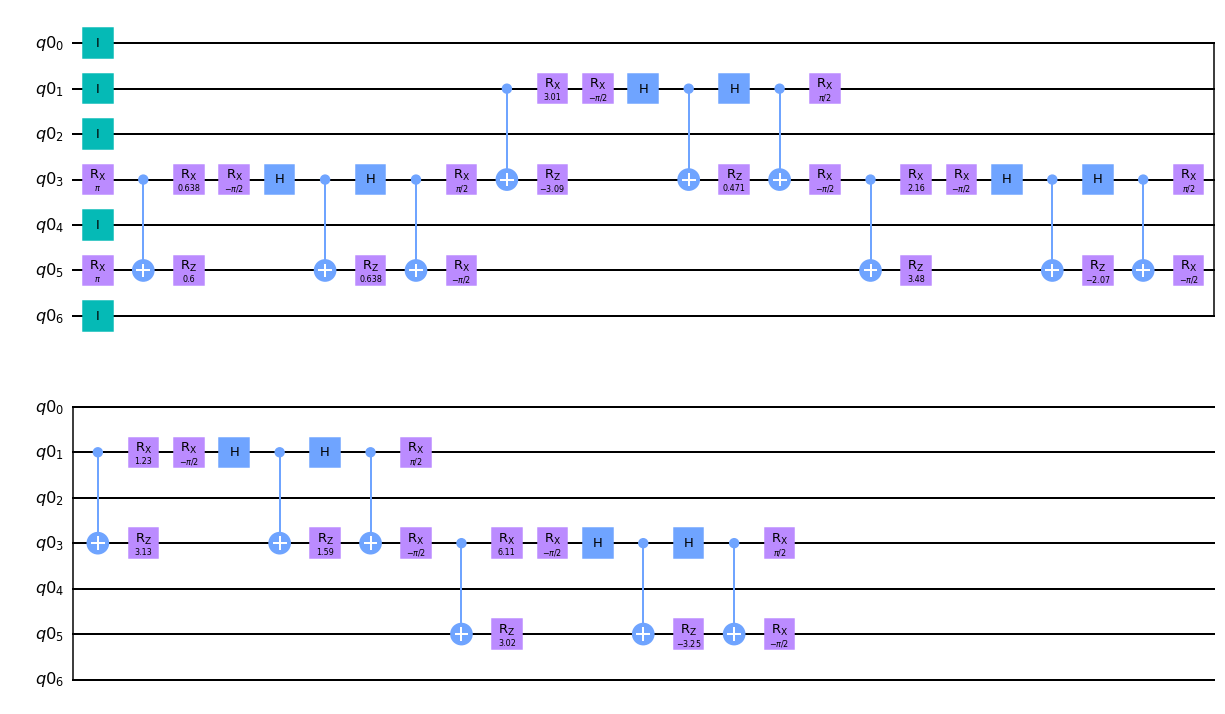

In [28]:
#fc = final_circ(ybe_optimal)
fqc.decompose().draw(output="mpl")

In [47]:
## Import functions that are needed for the tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [48]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-05 09:59:36,881: Credentials are already in use. The existing account in the session will be replaced.


In [49]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
#sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [50]:
# Setting all the parameters that are need
shots = 8192
backend = jakarta

In [34]:
# Create the tomography circuits
st_qcs = state_tomography_circuits(fqc.decompose(), [fqr[1], fqr[3], fqr[5]])

## 3.2.1 Submit jobs 

In [60]:
# Repeat fidelity measurement
reps = 8 
job_id_list = []
    
# Now launch the jobs
for count in range(reps):
    print("\n REPETITION "+str(count+1)+"\n")
    zne_job_id = zne_job_launch(st_qcs, backend=backend, optimization_level=0, shots=shots, scale_factors=scale_factors)
    job_id_list.append(zne_job_id)


 REPETITION 1

JOB 624bf80372af3f1d39ca58a6 SUBMITTED

 REPETITION 2

JOB 624bf82e72af3f0c47ca58a8 SUBMITTED

 REPETITION 3

JOB 624bf86172af3f7de7ca58a9 SUBMITTED

 REPETITION 4

JOB 624bf8a843644d4410949334 SUBMITTED

 REPETITION 5

JOB 624bf8e843644d7e94949336 SUBMITTED

 REPETITION 6

JOB 624bf92b72af3f55c2ca58ad SUBMITTED

 REPETITION 7

JOB 624bf962be0ba32789f12f17 SUBMITTED

 REPETITION 8

JOB 624bf99043644df49094933c SUBMITTED


In [61]:
job_id_list

['624bf80372af3f1d39ca58a6',
 '624bf82e72af3f0c47ca58a8',
 '624bf86172af3f7de7ca58a9',
 '624bf8a843644d4410949334',
 '624bf8e843644d7e94949336',
 '624bf92b72af3f55c2ca58ad',
 '624bf962be0ba32789f12f17',
 '624bf99043644df49094933c']

In [53]:
# For convenience we provide the job ids we obtained for a previous run on hardware,
# the needs to be updated if the fidelity measurement is repeated again
job_id_list = ['623f2b1ed97bffed4c69508b',
'623f2b3f0af65dbf3dd93d91',
'623f2b60d97bff7ce369508f',
'623f2b8219e6894babc81713',
'623f2ba309995c2ba64932af',
'623f2bc374de0ec93f85b846',
'623f2be4d97bff59ad695094',
'623f2c058293e94ac21e66d4']

## 3.2.2 Collect results and compute fidelity

In [54]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [56]:
ibmq_fids = []

# Loop over the 8 fidelity measurements, perform error mitigation on the counts 
# and compute the fidelity for every experiment
for job in job_id_list:
    zne_res, zne_circs = zne_results_collect_nofile(backend=backend,jobid=job,tomo_circs=st_qcs, zne_order=3, shots=shots, scale_factors=scale_factors)
    zne_res_physical = remove_unphysical_bitstrings(zne_res)
    ibmq_fids.append(state_tomo(zne_res_physical, zne_circs))

In [57]:
## Print the final result
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(ibmq_fids), np.std(ibmq_fids)))

state tomography fidelity = 0.8822 ± 0.0197
